In [1]:
using Revise

In [2]:
using
    UnitsToValue,
    Printf,
    Plots,
    ImageFiltering
;

include("CaOH_package.jl")
include("helper_functions.jl")
include("analyze_results.jl")
include("load_save_results.jl")
;

## Define CaOH Hamiltonian and molecular states

In [3]:
package = get_CaOH_package(); # loads molecular structure (the states, their energy, Zeeman Hamiltonian, etc)
package_A = get_CaOH_package_12_A_states(); # this includes more A states, for calculating AC Stark shift in the ODT.
k = package.k
Γ = package.Γ
m = package.m;

## Define experimental parameters

In [5]:
3.5/(2.8+3.7)

0.5384615384615384

In [6]:
function get_Δ_from_exp(voltage, aom1_freq, aom2_freq)
    # return Δ1, Δ2 in MHz
    Δ1 = 52 - 7.4*(5.5-voltage)
    Δ3 = Δ1 + 51.24 - aom1_freq
    Δ4 = Δ1 + 51.24 - aom2_freq
    return Δ1, Δ3, Δ4
end


## Initial condition of the molecule cloud
temp = @with_unit 100e-3 "mK"
diameter = @with_unit 0.6 "mm"
displacement = [0.0, 0.0, 0.0]*1e-3
kick = [0,0, 0.0, 0.0]
 
## Define B field gradient and ramp time
B_gradient = -75; ramp_time = 4e-3

## Laser detunings
detuning_voltage = -0.5
aom1_freq = 53.75
aom2_freq = 52
Δ1, Δ3, Δ4 = get_Δ_from_exp(detuning_voltage, aom1_freq, aom2_freq).*(1e6*2π)
Δ2 = 0.0


## Laser intensities
intensity_voltage = 0.9
power_total = intensity_voltage * 13.1 /2.2 # mW

r1 = 3.7
r3 = 2.8 
r4 = 3.5

# r1 = 1
# r3 = 1
# r4 = 0

p1 = r1/(r1+r4+r3) * power_total
p3 = r3/(r1+r4+r3) * power_total
p4 = r4/(r1+r4+r3) * power_total

s1 = 2 * p1 / (π * 0.5^2) / 3.4
s2 = 0.0
s3 = 2 * p3 / (π * 0.5^2) / 3.4
s4 = 2 * p4 / (π * 0.5^2) / 3.4



blue_MOT_params = MutableNamedTuple(t_start = 0.0, t_end = 5e-3, n_values = 1000,
                                pol1_x=σ⁺, pol2_x=σ⁻, pol3_x=σ⁻, pol4_x=σ⁺, 
                                s1=s1, s2=s2, s3=s3, s4=s4,
                                Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4, 

                                B_gradient = B_gradient, 
                                B_ramp_time = ramp_time,
                                Bz_offset = 0.0, By_offset = 0.0, Bx_offset=0.0,

                                temp=temp, diameter=diameter, 
                                displacement=displacement, kick=kick,
                                s_ramp_time = ramp_time,
                                s_ramp_to_factor = 7/9,

                                photon_budget=Inf, dark_lifetime=1/(0.7e6)*Γ, FC_mainline=1,

                                pol_imbalance=0.0, 
                                s_imbalance = (0., 0., -0.), retro_loss=0., 
                                off_center=[0, -0, -0, 0, 0, 0].*1e-3, 
                                pointing_error =[0.0, 0.0, 0.0,0.0,0,0],

                                ODT_intensity = 0*13.3*1e3/(50e-4)^2,
                                ODT_size = (30e-6, 2e-3, 30e-6), 
                                ODT_revolutions = 3,
                                ODT_rmax = 100e-6, # distance of radial motion
                                ODT_tmax = 30e-3, # timescale of radial motion
                                ODT_motion_t_start = 30e-3,
                                ODT_motion_t_stop = 50e-3,

                                dt = 1e-2,

                                diffusion_constant =0.0)
;

## Find the diffusion constant

In [7]:
diffusion_constant = find_diffusion_constant(blue_MOT_params, run_time=1e-4, n_particles=20, 
                                            ramp_time=1e-6, temp = 1e-4, diameter=60e-6)
@printf("Diffusion constant = %.2f \n", diffusion_constant)

blue_MOT_params.diffusion_constant = diffusion_constant;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


Diffusion constant = 1.22 


## Run a constant-diffusion simulation
Define an experimental sequence. In this example, it's just the blue MOT. But we could also simulate an entire experimental sequence, such as 
red MOT -> lambda cooling -> blue MOT -> single frequency cooling -> ODT loading

In [8]:
sequence = [blue_MOT_params]
durations = [12e-3]
generate_sequence!(sequence, durations);
@time results_nodiff= simulate_particles_constant_diffusion(package, package_A, sequence);

Progress: 100%|█████████████████████████████████████████| Time: 1:27:38m


5259.039850 seconds (12.14 M allocations: 1.034 GiB, 0.01% gc time, 3.33% compilation time)


In [14]:
log_test_info("",20,blue_MOT_params)
save_results("", 20,results_nodiff);

In [334]:
max_t_id = 1
plot_ts = Float64[]
for i in 1:length(results_d.times)
     if length(results_d.times[i]) > max_t_id
          max_t_id = length(results_d.times[i])  
         plot_ts = results.times[i]
     end                                                                                                          
 end 
trapped = []       
out_x= [] 
out_y = []
out_z = []                                                                
for i in 1:length(results_d.times)
     if length(results_d.times[i]) == max_t_id   
        d_x = results_d.sum_diffusion_x[i] / results_d.photons_scattered[i]
        d_y = results_d.sum_diffusion_y[i] / results_d.photons_scattered[i]
        d_z = results_d.sum_diffusion_z[i] / results_d.photons_scattered[i]
        if d_x + d_y + d_z > 20
            continue
        end
         push!(trapped, i)
        push!(out_x, results_d.sum_diffusion_x[i] / results_d.photons_scattered[i])
        push!(out_y, results_d.sum_diffusion_y[i] / results_d.photons_scattered[i])
        push!(out_z, results_d.sum_diffusion_z[i] / results_d.photons_scattered[i])
     end                                                                                   
end;

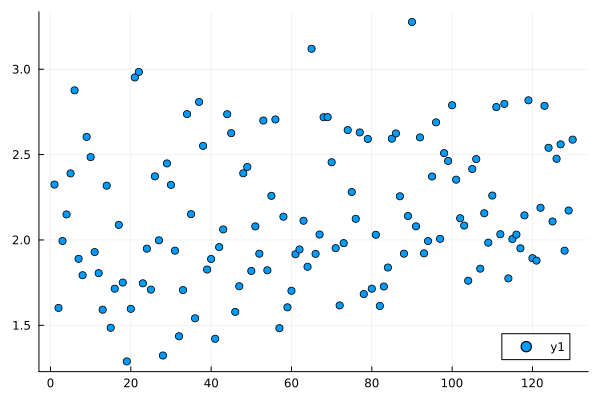

In [337]:
scatter(sqrt.(out_z))

In [339]:
sqrt(mean(out_z))

2.19029864583599

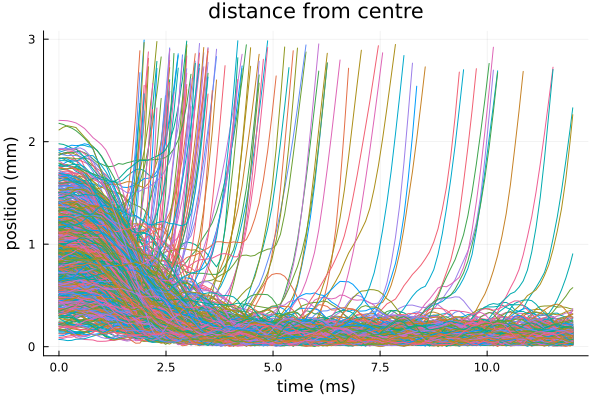

In [21]:
plot_all_trajectories(results_nodiff, "all")
plot!()

In [252]:
bootstrap_size_fit(results_, 15; iter=100, range=0.5, n_grids=20)

(0.11213629805652602, 0.022629207422091027)

In [256]:
bootstrap_temperature_fit(results_, 15; iter=100)

(200.69642532455305, 79.61244983311857)

In [259]:
bootstrap_survival(results_,15; iter=100)

(0.02525033519820956, 0.002476850262800693)

210.43056554387408
672.8885119317262


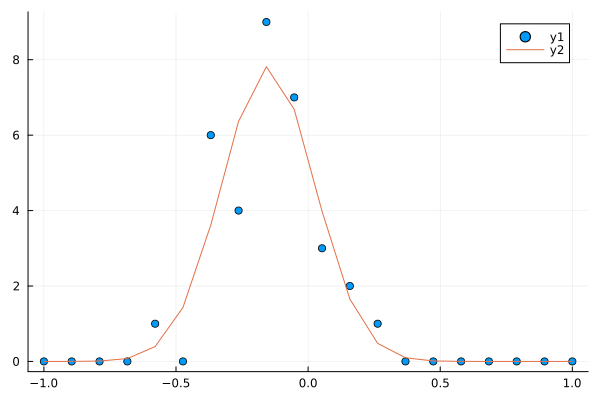

In [251]:
n_values = 500
results = results_
t_end = 15

sizes = []
x_grid = collect(LinRange(-1, 1, 20))

results1 = bootstrap_iteration(results, n_values=n_values)

id_survived = survived_t(results1, t_end)

xs = [results1.z_velocities[j][end] for j in id_survived]
density_x = distribution_to_func(x_grid, xs)


p0 = [10, 0.1,0.0]
fit = curve_fit(gaussian, x_grid, density_x, p0);
k_B = 1.38e-23

# println(fit.param[2])
# println(plot_size(results1, "z")[2][end])
println(m * fit.param[2]^2 /k_B *1e6)

println(plot_temperature(results1, "z")[2][end])
scatter(x_grid, density_x)
plot!(x_grid, gaussian(x_grid, fit.param))

### Or load an existing simulation result
The example here is a 1000 particle blue MOT simulation for 7.1 ms

In [12]:
results = load_results("",3);
# results_2 = load_results("", 4);

In [96]:
size_file_path = "X:\\Shared drives\\CaOH exp\\Papers\\CaOH_BlueMOT\\Analysis\\Figure4\\size_vs_time_3freq\\size_vs_time_3freq_extrapoints.mat"
size_file = matread(size_file_path);
data_ts = vcat(data_ts, data_ts)

6-element Vector{Float64}:
 1.7
 3.4
 5.1
 1.7
 3.4
 5.1

In [24]:
using MAT

size_file_path = "X:\\Shared drives\\CaOH exp\\Papers\\CaOH_BlueMOT\\Analysis\\Figure4\\size_vs_time_3freq\\size_vs_time_3freq.mat"
size_file = matread(size_file_path);
data_ts = size_file["all_params"][2:4];
data_sizes = size_file["widths_x"][2:4].^(2/3) .* size_file["widths_y"][2:4].^(1/3)

number_file_path = "X:\\Shared drives\\CaOH exp\\Papers\\CaOH_BlueMOT\\Analysis\\Figure4\\size_vs_time_3freq\\size_vs_time_3freq_numbers.mat"
number_file = matread(number_file_path);
data_ts_n = number_file["all_params"][1:4]
data_numbers = number_file["ampx1"][1:4]
norm1 = number_file["ampx1"][5]

size_file_path = "X:\\Shared drives\\CaOH exp\\Papers\\CaOH_BlueMOT\\Analysis\\Figure4\\size_vs_time_3freq\\size_vs_time_3freq_extrapoints.mat"
size_file = matread(size_file_path);
data_ts = vcat(data_ts, size_file["all_params"][:]);
data_sizes = vcat(data_sizes, size_file["widths_x"].^(2/3) .* size_file["widths_y"].^(1/3))

number_file_path = "X:\\Shared drives\\CaOH exp\\Papers\\CaOH_BlueMOT\\Analysis\\Figure4\\size_vs_time_3freq\\size_vs_time_3freq_numbers_extrapoints.mat"
number_file = matread(number_file_path);
data_ts_n = vcat(data_ts_n, number_file["all_params"][:]);
data_numbers = vcat(data_numbers, number_file["ampx1"]./(number_file["ampx1"][2]/norm1))




size_file_path2 = "X:\\Shared drives\\CaOH exp\\Papers\\CaOH_BlueMOT\\Analysis\\Figure4\\size_vs_time_2freq\\size_vs_time_2freq.mat"
size_file2 = matread(size_file_path2);
data_ts2 = size_file2["all_params"]';
data_sizes2 = size_file2["widths_x"].^(2/3) .* size_file2["widths_y"].^(1/3)

number_file_path2 = "X:\\Shared drives\\CaOH exp\\Papers\\CaOH_BlueMOT\\Analysis\\Figure4\\size_vs_time_2freq\\size_vs_time_2freq_numbers.mat"
number_file2 = matread(number_file_path2);
data_numbers2 = number_file2["ampx1"]
 

simulation_file_path = "X:\\Shared drives\\CaOH exp\\Papers\\CaOH_BlueMOT\\Analysis\\Figure4\\vs_time_simulations2.mat";

In [270]:
results2 = load_results("", 10);

In [35]:
ts = 0.1:0.5:12
sizes = Float64[]
errors = Float64[]

for t in ts
    size, error = bootstrap_size_fit(results_nodiff, t; iter=100, range=1.0)
    push!(sizes, size)
    push!(errors, error)
end

# ts_2 = 0.1:0.5:18
# sizes_2 = Float64[]
# errors_2 = Float64[]
# for t in ts_2
#     size, error = bootstrap_size_fit(results2, t; iter=100, range=1.0)
#     push!(sizes_2, size)
#     push!(errors_2, error)
# end

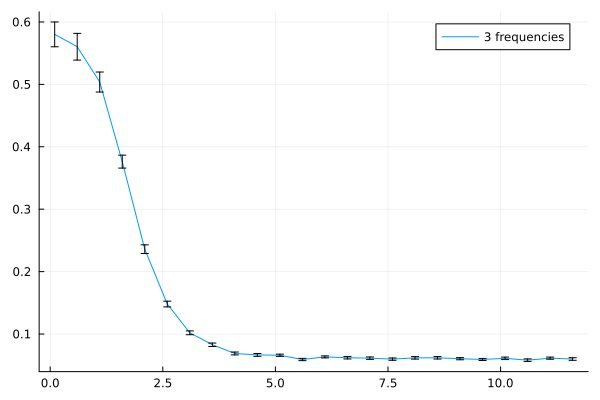

In [36]:
plot(ts, sizes, yerr=errors, label="3 frequencies")
# plot(ts_2, sizes_2, yerr=errors_2, label="2 frequencies")

In [46]:
numbers = Float64[]
n_errors = Float64[]
for t in ts
    n, error = bootstrap_survival(results_nodiff, t, rmax=2.0)
    push!(numbers, n)
    push!(n_errors, error)
end

# numbers_2 = Float64[]
# n_errors_2 = Float64[]
# for t in ts_2
#     n, error = bootstrap_survival(results2, t, rmax=4.0)
#     push!(numbers_2, n)
#     push!(n_errors_2, error)
# end

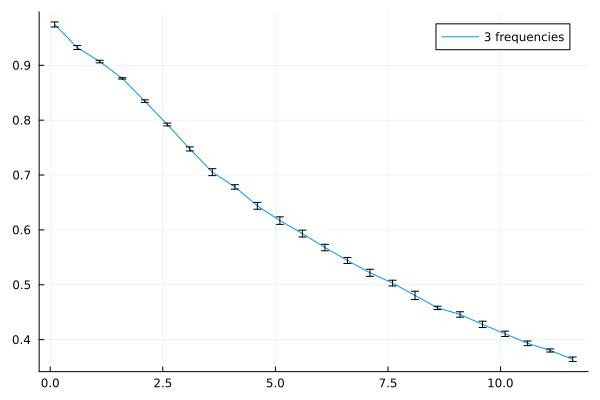

In [47]:
plot(ts, numbers, yerr=n_errors, label="3 frequencies")
# plot!(ts_2, numbers_2, yerr=n_errors_2, label="2 frequencies")

In [48]:
# units = 1e3 * 5000/0.6

# densities = numbers./sizes.^3 * units / (2π)^(3/2)
# densities_2 = numbers_2./sizes_2.^3 * units / (2π)^(3/2)

# density_error = sqrt.((n_errors./sizes.^3).^2 + (3 .*errors.*numbers./sizes.^4).^2)* units / (2π)^(3/2)
# density_error_2 = sqrt.((n_errors_2./sizes_2.^3).^2 + (3 .*errors_2.*numbers_2./sizes_2.^4).^2)* units / (2π)^(3/2)


# plot(ts, densities, yerr=density_error,label="3 frequencies")
# plot!(ts_2, densities_2,yerr=density_error_2, label="2 frequencies")
# plot!(yscale=:log)

In [49]:
using DSP

n = 5
kernel = ones(n)./n

ts_avg = conv(ts, kernel)[n: end-n+1]
sizes_avg = conv(sizes, kernel)[n:end-n+1]
errors_avg = conv(errors, kernel)[n:end-n+1]
numbers_avg = conv(numbers, kernel)[n:end-n+1]
n_errors_avg = conv(n_errors, kernel)[n:end-n+1]

# ts_avg_2= conv(ts_2, kernel)[n:end-n+1]
# sizes_avg_2 = conv(sizes_2, kernel)[n:end-n+1]
# errors_avg_2 = conv(errors_2, kernel)[n:end-n+1]
# numbers_avg_2 = conv(numbers_2, kernel)[n:end-n+1]
# n_errors_avg_2 = conv(n_errors_2, kernel)[n:end-n+1];
;

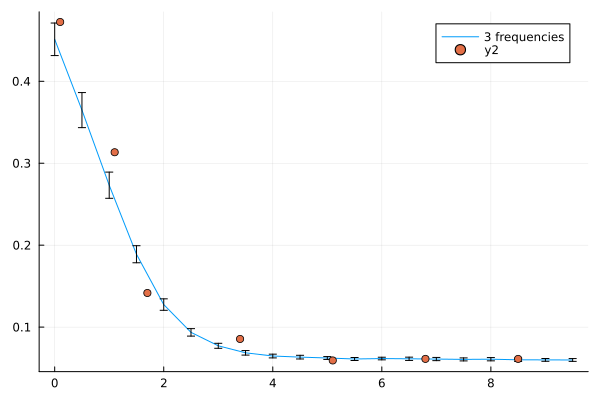

In [50]:
plot(ts_avg .- ts_avg[1], sizes_avg, yerr=errors, label="3 frequencies")
# plot(ts_avg_2 .- ts_avg_2[1], sizes_avg_2, yerr=errors_2, label="2 frequencies")
scatter!(data_ts, data_sizes)
# scatter!(data_ts2, data_sizes2)

In [51]:
bootstrap_temperature_fit(results_nodiff,5; iter=100)

(165.6039847098169, 10.87426720343541)

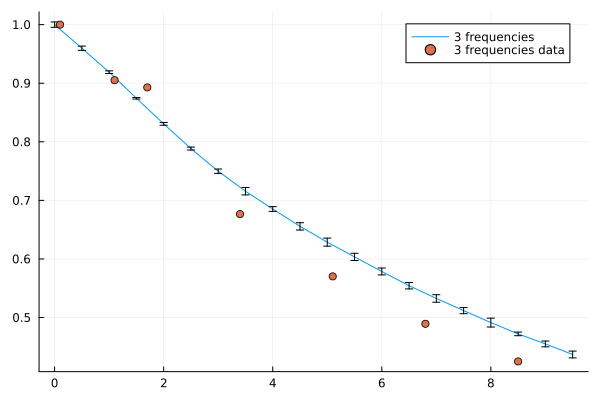

In [52]:
# numbers_avg_2 = numbers_avg_2 ./ numbers_avg_2[1]
# n_errors_2 = n_errors_2 ./ numbers_avg_2[1]

plot(ts_avg .- ts_avg[1], numbers_avg./numbers_avg[1], yerr=n_errors, label="3 frequencies")
# plot(ts_avg_2 .- ts_avg_2[1], numbers_avg_2, yerr=n_errors_2, label="2 frequencies")
scatter!(data_ts_n, data_numbers./data_numbers[1], label="3 frequencies data")
# scatter!(data_ts2, data_numbers2./data_numbers[1], label="2 frequencies data")

In [297]:
data_numbers2

5×1 Matrix{Float64}:
 0.00928085620812254
 0.00790764263896625
 0.004636399311279744
 0.0030721555314514033
 0.002246298490487576

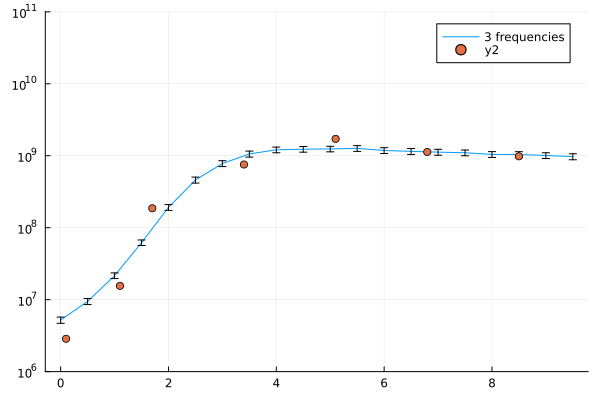

In [53]:
units = 1e3 * 5000/0.6

densities_avg = numbers_avg./sizes_avg.^3 * units / (2π)^(3/2)
# densities_avg_2 = numbers_avg_2./sizes_avg_2.^3 * units / (2π)^(3/2) 

density_errors_avg = sqrt.((n_errors_avg./sizes_avg.^3).^2 + (3 .*errors_avg.*numbers_avg./sizes_avg.^4).^2)* units / (2π)^(3/2)
# density_errors_avg_2 = sqrt.((n_errors_avg_2./sizes_avg_2.^3).^2 + (3 .*errors_avg_2.*numbers_avg_2./sizes_avg_2.^4).^2)* units / (2π)^(3/2)

densities_data = data_numbers./data_sizes.^3 * units / (2π)^(3/2) ./data_numbers[1]
plot(ts_avg .- ts_avg[1], densities_avg, yerr=density_errors_avg,label="3 frequencies")
# plot(ts_avg_2 .- ts_avg_2[1], densities_avg_2,yerr=density_errors_avg_2, label="2 frequencies")
scatter!(data_ts, densities_data)
plot!(yscale=:log, ylim=(1e6,1e11))

In [289]:
using MAT
simulation_file_path = "X:\\Shared drives\\CaOH exp\\Papers\\CaOH_BlueMOT\\Analysis\\Figure4\\vs_time_simulations_2freq.mat";

In [311]:
file = matopen(simulation_file_path, "w")

write(file, "ts_2", ts_avg_2.-ts_avg_2[1])

write(file, "simulation_sizes_2", sizes_avg_2)
write(file, "simulation_size_errors_2", errors_avg_2)

write(file, "simulation_signals_2", numbers_avg_2)
write(file, "simulation_signal_errors_2", n_errors_avg_2)

write(file, "simulation_densities_2", densities_avg_2)
write(file, "simulation_density_errors_2", density_errors_avg_2)

close(file);

In [201]:
close(file)

### Simulate camera images
We can also generate "camera images" by taking 2D snapshots (integrated over y direction) of the molecules.

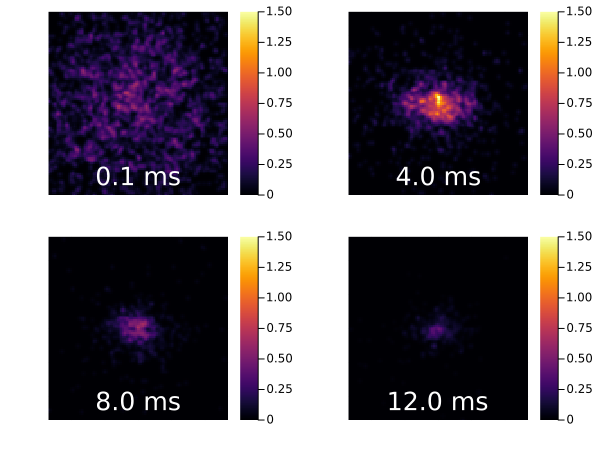

In [264]:
ROI = 0.8  # mm

img_duration = 2.0   # the image will be averaged over this duration
n_pixels = 100

ts = [0.1,4,8,12]
filter = 1.   # Gaussian filtering the image

plots = []
for t in ts
    x, z, grids = take_camera_image(results_, -ROI, ROI, n_pixels, t=t, t_img=img_duration, const_scattering=false, noise=0.0, photon_budget=12000)
    imgg = imfilter(grids, Kernel.gaussian(filter))
    p = heatmap(x,z,imgg',xaxis=false, yaxis=false, clim=(0,1.5))
    annotate!(0,-ROI*0.8,text(@sprintf("%.1f ms", t),:white,17))
    push!(plots, p)
end

plot(plots[1],plots[2],plots[3],plots[4], size=(600,450))
    
plot!()

In [43]:
using Serialization
saving_path2 = "C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\parameter_scans\\scan_2freq_pp1000_1_2.jl";
saving_path1 = "C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\parameter_scans\\scan_2freq_pp1000_1_1.jl";

In [44]:
results_list2 = deserialize(saving_path);
results_list1 = deserialize(saving_path1)
n = Int(length(results_list2))
aom2_freqs = 50.5:0.25:55;
aom2_freqs = aom2_freqs[1:n]

50.5:0.25:54.75

In [45]:
results_list = []
for i in 1:n
    merged = merge_results([results_list1[i], results_list2[i]])
    push!(results_list, merged)
end

In [46]:
sizes = []
size_errors = []
for results in results_list[1:end]
    size, error = bootstrap_size_fit(results, 10; iter=100, range=0.5, n_grids=15,rmax=1.0)
    push!(sizes, size)
    push!(size_errors, error)
end

signals = []
signal_errors = []

for results in results_list[1:end]
    signal, error = bootstrap_survival(results,10, iter=100,rmax=1.0)
    push!(signals, signal)
    push!(signal_errors, error)
end;

temperatures = []
temp_errors = []
for results in results_list[1:end]
    signal, error = bootstrap_temperature_fit(results,10; iter=100, range=0.5, n_grids=20)
    push!(temperatures, signal)
    push!(temp_errors, error)
end
;

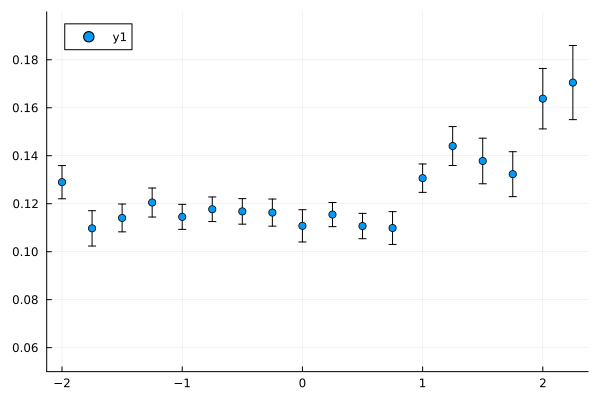

In [47]:
scatter(52.75 .- collect(aom2_freqs),sizes, yerr=size_errors, ylim=[0.05,0.2])

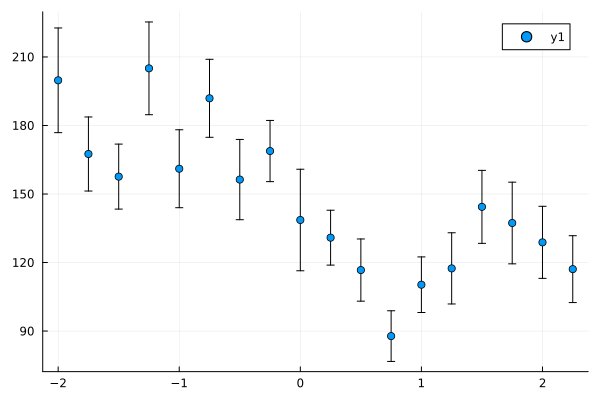

In [48]:
scatter(52.75 .- collect(aom2_freqs),temperatures, yerr=temp_errors)

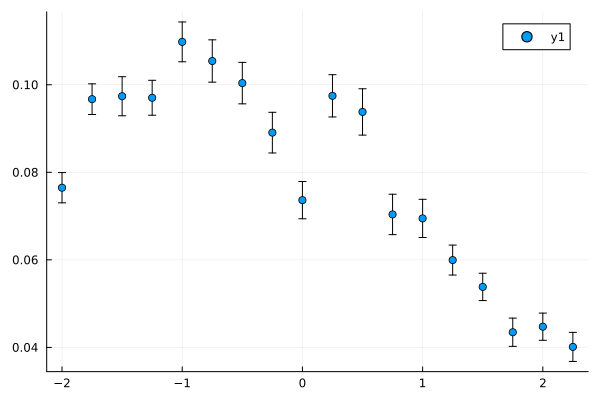

In [49]:
scatter(52.75 .- collect(aom2_freqs),signals, yerr=signal_errors)

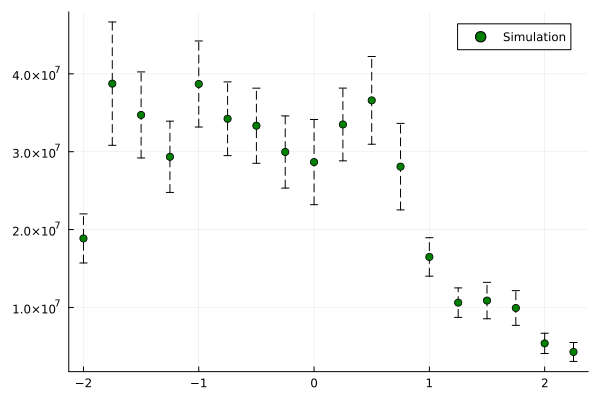

In [50]:
units = 1e3 * 5000/0.6
densities = signals./sizes.^3 * units / (2π)^(3/2)
density_errors = sqrt.((signal_errors ./ sizes.^3).^2 + (3 .* size_errors .* signals ./sizes.^4).^2) * units / (2π)^(3/2)

scatter(52.75 .- collect(aom2_freqs), densities, yerr=density_errors ,color="green",linestyle=:dash,label="Simulation",
ribbon=(size_errors, size_errors),fc=:green,fa=0.2)

plot!()

In [52]:
using MAT

simulation_file_path = "X:\\Shared drives\\CaOH exp\\Papers\\CaOH_BlueMOT\\Analysis\\Figure4\\2freq_pp_simulations.mat";
file = matopen(simulation_file_path, "w")
write(file, "aom1_freqs", collect(aom2_freqs)[1:end])

write(file, "simulation_sizes", sizes)
write(file, "simulation_size_errors", size_errors)

write(file, "simulation_signals", signals)
write(file, "simulation_signal_errors", signal_errors)

write(file, "simulation_densities", densities)
write(file, "simulation_density_errors", density_errors)

close(file);

In [158]:
bootstrap_size_fit(results_list[end],10; iter=100, range=0.5, n_grids=15)

(0.11938779869219102, 0.012609584343176196)

0.11437392019216346
0.14279389161285844
0.08024506585044305
0.1094338448861322


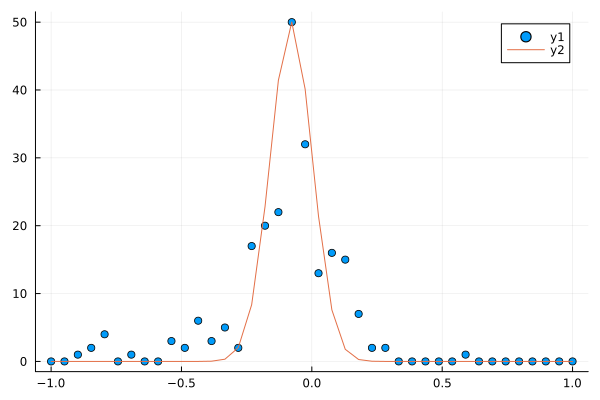

In [227]:
results = results_list[end-3]
range = 1.0
n_grids = 40
n_values = 1000
t = 10

x_grid = collect(LinRange(-range, range, n_grids))
dt = results.times[1][2]-results.times[1][1]
t_j = Int(floor(t ÷ dt))


results1 = bootstrap_iteration(results, n_values=n_values)

id_survived = survived_t(results1, t)

xs = [results1.x_trajectories[j][t_j] for j in id_survived]
density_x = distribution_to_func(x_grid, xs)
p0 = [10, 0.2, 0.0]
fit_x = curve_fit(gaussian, x_grid, density_x, p0)
sx = fit_x.param[2]

ys = [results1.y_trajectories[j][t_j] for j in id_survived]
density_y = distribution_to_func(x_grid, ys)
p0 = [10, 0.2, 0.0]
fit_y = curve_fit(gaussian, x_grid, density_y, p0)
sy = fit_y.param[2]

zs = [results1.z_trajectories[j][t_j] for j in id_survived]
density_z = distribution_to_func(x_grid, zs)
p0 = [10, 0.2, 0.0]
fit_z = curve_fit(gaussian, x_grid, density_z, p0)
sz = fit_z.param[2]



println(sx)
println(sy)
println(sz)
println((sx*sy*sz)^(1/3))

scatter(x_grid, density_x)
plot!(x_grid, gaussian(x_grid, fit_z.param))

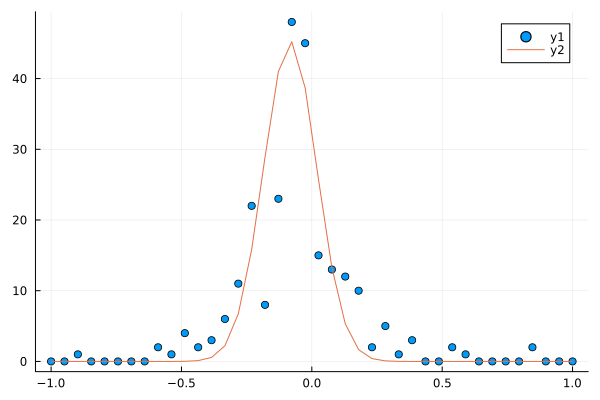

0.18855736190756095


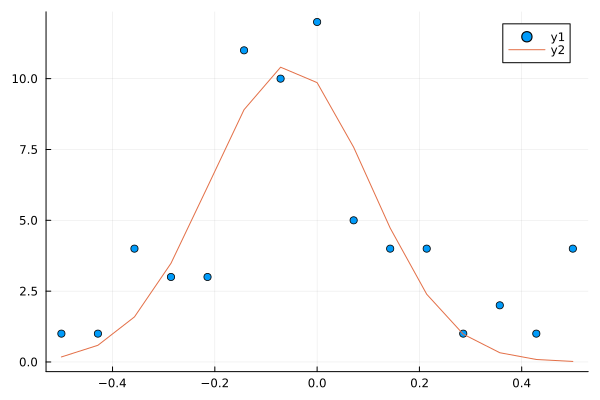

In [154]:
n_values = 1000
results = results_list[end]

sizes = []
x_grid = collect(LinRange(-0.5, 0.5, 15))

results1 = bootstrap_iteration(results, n_values=n_values)

id_survived = survived_t(results,10)

xs = [results1.x_trajectories[j][end] for j in id_survived]
density_x = distribution_to_func(x_grid, xs)


p0 = [10, 0.1,0.0]
fit = curve_fit(gaussian, x_grid, density_x, p0);
k_B = 1.38e-23

# println(fit.param[2])
println(plot_size(results1, "x")[2][end])
#     println(m * fit.param[2]^2 /k_B *1e6)

# println(plot_temperature(results1, "x")[2][end])
scatter(x_grid, density_x)
plot!(x_grid, gaussian(x_grid, fit.param))